# Counting the number of quasi-loop in neuromorpho data

We want to find how many neurons in neuromorpho data has something simlar to a loop. We define a quasi-loop as followoing:

#### Definition of Quasi-loop: 
Suppose that \\( t_1\\) and  \\( t_2\\) are two terminals of a neuron  and  \\( A_1\\) and  \\( A_1\\) are the set of their ancestors. Then neuron has quasi-loop with \\( t_1\\) and  \\( t_2\\) if

(1) \\( \text{dist} (t_1, t_2) < \text{thrs}_1 \\) and

(2) if \\( t\\)  is the mean of \\( t_1\\) and  \\( t_2\\) then \\( \text{dist} ( A_1 \cap A_2, t) < \text{thrs}_2 \\)

Where \\( \text{thrs}_1, \text{thrs}_2 \\) are two thresholds.

#### Here we:
Given a neuron, we count the number of quasi-loops for 5 pairs of thresholds:
\\( \text{thrs}_1, \text{thrs}_2 = (1, 20), (2, 20), (5, 20), (10, 20), (1, 10)\\)

We filter the mouse/rat data and divide it to the brain regions and 

## Imports

In [2]:
import sys
sys.path.append("/home/roozbeh/Morphology/McNeuron")
import urllib
import numpy as np
import pandas as pd
import pickle
import McNeuron
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial import distance as dis
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib
from matplotlib import collections as mc
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib.patches as mpatches
import itertools
import math
from copy import deepcopy
%matplotlib inline

Upload pre-downloaded data from neuromorpho

In [3]:
path='/home/roozbeh/Morphology/Data processing/'
neurons_v76 = pd.read_pickle(path+'neurons_v76.csv')
attribute_mat = pickle.load(open(path+'attribute_mat_neurons_v76.csv', 'rb'))
labels_encoder = pickle.load(open(path+'labels_encoder_neurons_v76.csv', 'rb'))

dis_1_20 = pickle.load(open(path+'dis_1_20.csv', 'rb'))
dis_2_20 = pickle.load(open(path+'dis_2_20.csv', 'rb'))
dis_5_20 = pickle.load(open(path+'dis_5_20.csv', 'rb'))
dis_10_20 = pickle.load(open(path+'dis_10_20.csv', 'rb'))

retina_loops_maxthrs1_10_thrs2_20 = \
    pickle.load(open(path+'retina_loops_maxthrs1_10_thrs2_20.csv', 'rb'))

## Functions to get loops

To get the loops we need two functions: (1) finding terminals and (2) get the ancestors of a node. 

In [4]:
def get_ancestors(parent_index, node):
    """
    Return the ancestors of a node on the neuron toward the root. 
    
    Parameters:
    -----------
    parent_index: numpy array
        the parent index of the nodes
        
    nodes: int
        Index of the node
    
    Returns:
    --------
    ancestors: list
        the list of ancestors of the node.
        
    """

    ancestors = []
    ancestors.append(node)
    par = node
    while par!=0:
        par = parent_index[par]
        ancestors.append(par) 
    return ancestors

def n_loops_in_neuron(neuron, 
                      thr_tips, 
                      thr_origin_loop):
    """
    Return number of quasi-loops and the pairs of endpoints that have made the loop. 
    This function forst identified the pairs of endpoints of neuron that their distance
    is less than thr_tips. Then if Euclidean distance of the mean of this pair and all 
    the shared ancestor is higher than thr_origin_loop, it considers it as a quasi-loop.
    Parameters:
    -----------
    neuron: McNeuron neuron
        
    thr_tips: float
          threshold for the distance of pairs of endpoints
    
    thr_origin_loop: float
        threshold for distance between the mean of pairs and all share ancestors.
    
    Returns:
    --------
    n_loops: int
        number of loops. 
    
    list_endpont_loops: list
        the list of pairs of endpoints
    """  
    branching_order = McNeuron.tree_util.branch_order(neuron.parent_index)
    endpoints = np.where(branching_order==0)[0]
    pair_distance_endpoints = dis.squareform(dis.pdist(neuron.location[:, endpoints].T,
                                                       'euclidean'))
    pair_distance_endpoints = np.triu(pair_distance_endpoints, k=0)
    pair_distance_endpoints[pair_distance_endpoints==0] = np.infty
    endpoints1, endpoints2 = np.where(pair_distance_endpoints<thr_tips)

    n_loops = 0
    list_endpont_loops = []
    for i in range(len(endpoints1)):
        p1 = endpoints[endpoints1[i]]
        p2 = endpoints[endpoints2[i]]
        centroid = .5*(neuron.location[:, p1] + neuron.location[:, p2])

        ancestors_p1 = get_ancestors(neuron.parent_index, p1)
        ancestors_p2 = get_ancestors(neuron.parent_index, p2)
        shared_ancestors = np.intersect1d(np.array(ancestors_p1), 
                                   np.array(ancestors_p2))
        distance_from_shared_ancestors = \
            sum((neuron.location[:, shared_ancestors] - np.expand_dims(centroid,1))**2,1)
        if min(distance_from_shared_ancestors) > thr_origin_loop**2:
            list_endpont_loops.append([p1, p2])
            n_loops +=1
    return n_loops, list_endpont_loops

def get_n_loops(neuron_data, thr_tips=1, thr_origin_loop=20):
    """
    Return number of quasi-loops and the pairs of endpoints that have made the loop. 
    This function forst identified the pairs of endpoints of neuron that their distance
    is less than thr_tips. Then if Euclidean distance of the mean of this pair and all 
    the shared ancestor is higher than thr_origin_loop, it considers it as a quasi-loop.
    Parameters:
    -----------
    neuron: McNeuron neuron
        
    thr_tips: float
          threshold for the distance of pairs of endpoints
    
    thr_origin_loop: float
        threshold for distance between the mean of pairs and all share ancestors.
    
    Returns:
    --------
    n_loops: int
        number of loops. 
    
    list_endpont_loops: list
        the list of pairs of endpoints
    """ 
    
    count_loop_in_neurons = []
    name_neuron = []
    for neuron_index in np.array(neuron_data.index):
        neuron = McNeuron.Neuron(neuron_data['swc'][neuron_index])
        n_loops, list_endpont_loops = n_loops_in_neuron(neuron=neuron, 
                                                        thr_tips=thr_tips, 
                                                        thr_origin_loop=thr_origin_loop)
        count_loop_in_neurons.append(n_loops)
        name_neuron.append(neuron_data['NeuroMorpho.Org ID'][neuron_index])

        loops = pd.DataFrame({'NeuroMorpho.Org ID':name_neuron,
                 'n_loop':count_loop_in_neurons})
    return loops

## Compute the number of neurons for a range of thresholds

5 pairs of values are considered to find a loop in neuron. We consider the neurons of mouse/rat where the experimntal condition is 'control'. For each pairs of values, the number of quasi-loops are counted.

In [ ]:
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']},
                ]
mouse_neurons = McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
                attribute_mat=attribute_mat,
                labels_encoder=labels_encoder,
                labels_values=labels_values)

dis_1_20 = get_n_loops(neuron_data=mouse_neurons, thr_tips=1, thr_origin_loop=20)
dis_2_20 = get_n_loops(neuron_data=mouse_neurons, thr_tips=2, thr_origin_loop=20)
dis_5_20 = get_n_loops(neuron_data=mouse_neurons, thr_tips=5, thr_origin_loop=20)
dis_10_20 = get_n_loops(neuron_data=mouse_neurons, thr_tips=10, thr_origin_loop=20)
dis_1_10 = get_n_loops(neuron_data=mouse_neurons, thr_tips=1, thr_origin_loop=10)

pickle.dump(dis_1_20, open(path+'dis_1_20.csv', 'wb'))
pickle.dump(dis_2_20, open(path+'dis_2_20.csv', 'wb'))
pickle.dump(dis_5_20, open(path+'dis_5_20.csv', 'wb'))
pickle.dump(dis_10_20, open(path+'dis_10_20.csv', 'wb'))
pickle.dump(dis_1_20, open(path+'dis_1_10.csv', 'wb'))

In [5]:
def loop_per_regions(regions, 
                     neurons, 
                     attribute_mat,
                     labels_encoder,
                     labels_values,
                     n_loops_per_neuron):

    mean_loops_per_regions = []
    for name in regions:
        mouse_neurons_regions = \
            McNeuron.data_util.get_neurons_with_given_values(neurons=neurons,
            attribute_mat=attribute_mat,
            labels_encoder=labels_encoder,
            labels_values=labels_values+[{'brain_region': name}])
        mouse_neurons_regions_loop = pd.merge(mouse_neurons_regions,
                                    n_loops_per_neuron, 
                                    on='NeuroMorpho.Org ID',
                                    how='inner') 
        mean_loops_per_regions.append(np.mean(mouse_neurons_regions_loop['n_loop']))
    return mean_loops_per_regions

In [6]:
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']},
                ]

regions = [
    ['somatosensory', 'primary somatosensory', 'barrel'],
    ['primary visual'],
    ['motor', 'secondary motor', 'primary motor'],
    ['CA1'],
    ['CA3'],
    ['dentate gyrus'],
    ['amygdala'],
    ['brainstem'],
    ['striatum', 'ventral striatum'],
    ['main olfactory bulb'],
    ['retina'],
    ['spinal cord'],
    ['anterior cingulate'],
    ['prelimbic'],
    ['dorsal thalamus', 'ventral thalamus', 'thalamus'],
    ['hypothalamus'],
    ['cerebellum'],
    ['entorhinal cortex'],
]
regions_name = ('somatosensory',
    'primary visual',
    'primary motor',
    'CA1',
    'CA3',
    'dentate gyrus',
    'amygdala',
    'brainstem',
    'striatum',
    'main olfactory bulb',
    'retina',
    'spinal cord',
    'anterior cingulate',
    'prelimbic',
    'thalamus',
    'hypothalamus',
    'cerebellum',
    'entorhinal cortex')
n_loop_dis_1_20 = loop_per_regions(regions=regions,
                                   neurons=neurons_v76, 
                                   attribute_mat=attribute_mat,
                                   labels_encoder=labels_encoder,
                                   labels_values=labels_values,
                                   n_loops_per_neuron=dis_1_20)

n_loop_dis_2_20 = loop_per_regions(regions=regions,
                                   neurons=neurons_v76, 
                                   attribute_mat=attribute_mat,
                                   labels_encoder=labels_encoder,
                                   labels_values=labels_values,
                                   n_loops_per_neuron=dis_2_20)

n_loop_dis_5_20 = loop_per_regions(regions=regions,
                                   neurons=neurons_v76, 
                                   attribute_mat=attribute_mat,
                                   labels_encoder=labels_encoder,
                                   labels_values=labels_values,
                                   n_loops_per_neuron=dis_5_20)

n_loop_dis_10_20 = loop_per_regions(regions=regions,
                                   neurons=neurons_v76, 
                                   attribute_mat=attribute_mat,
                                   labels_encoder=labels_encoder,
                                    labels_values=labels_values,
                                   n_loops_per_neuron=dis_10_20)


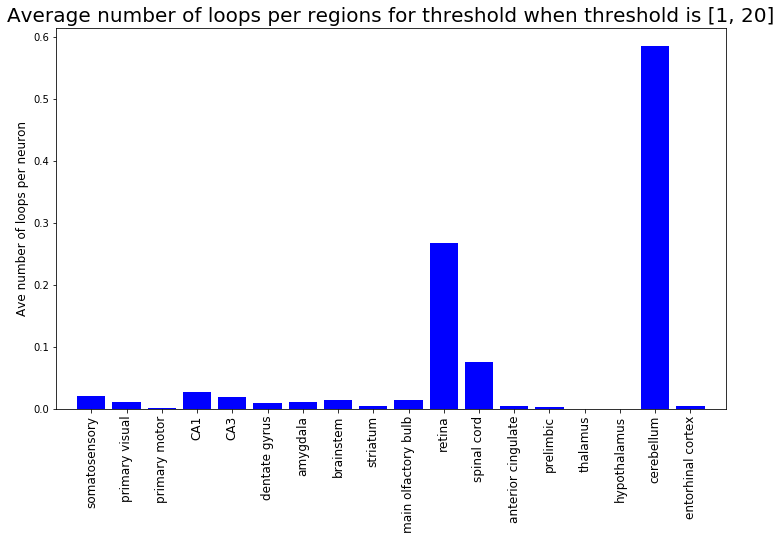

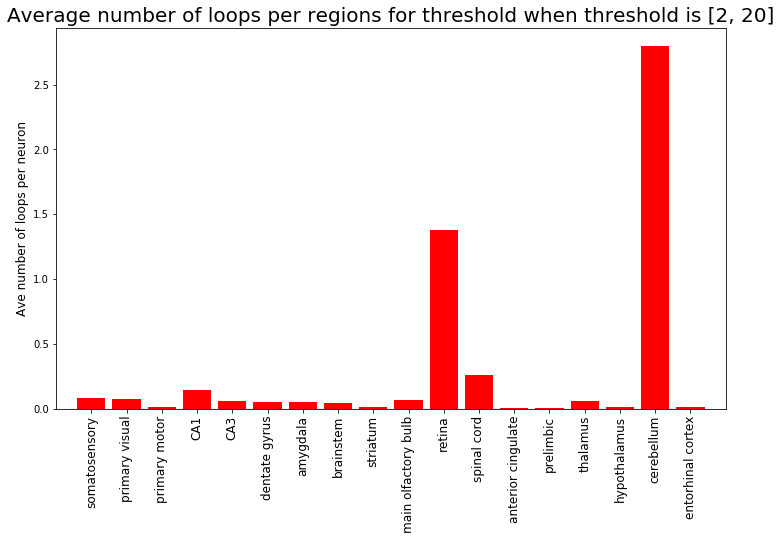

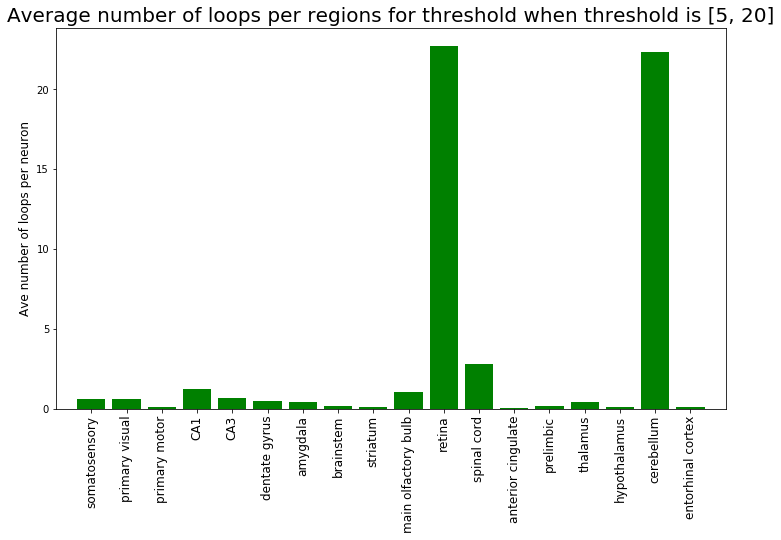

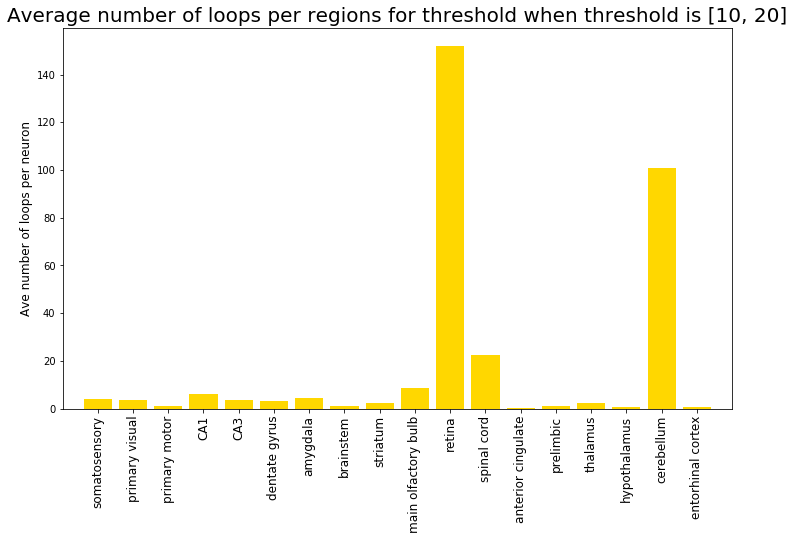

In [7]:
def plot_stat(title,
              regions_name,
              color,
              height):
    n_regions = len(regions)
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_xlim(-1,n_regions)
    fontdict_title={'fontsize': 20, 'fontweight': 'medium'}
    fontdict_text={'fontsize': 12, 'fontweight': 'medium'}
    ax.bar(x=np.arange(n_regions), height=height, width=.8, color=color)
    ax.set_title(title, fontdict_title)

    ax.set_ylabel('Ave number of loops per neuron', fontdict=fontdict_text)
    ax.set_xticks(np.arange(n_regions))
    ax.set_xticklabels(regions_name,
                       rotation='vertical', 
                       fontdict=fontdict_text);
plot_stat(title='Average number of loops per regions for threshold when threshold is [1, 20]',
              regions_name=regions_name,
              color='blue',
              height=n_loop_dis_1_20)

plot_stat(title='Average number of loops per regions for threshold when threshold is [2, 20]',
              regions_name=regions_name,
              color='red',
              height=n_loop_dis_2_20)

plot_stat(title='Average number of loops per regions for threshold when threshold is [5, 20]',
              regions_name=regions_name,
              color='green',
              height=n_loop_dis_5_20)

plot_stat(title='Average number of loops per regions for threshold when threshold is [10, 20]',
              regions_name=regions_name,
              color='gold',
              height=n_loop_dis_10_20)

## Functions to plot the loop in the neuron

In [32]:
def rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

def plot_2D(neuron,
            show_width=False,
            show_soma=False,
            line_width=1,            
            color_line_width=1,
            color_range=['red', 'orange', 'gold', 'green', 'cyan',
              'blue', 'violet', 'gray', 'pink', 'brown', 'magenta'],
            node_index_red_after=-1,
            show_loop=[],
            red_index=np.array([]),
            node_color=[],
            shift=(0, 0),
            scale=(1, 1),
            save=[],
            pass_ax=False,
            axis=[1,0,0],
            rotation=0,
            ax=''):
    if isinstance(neuron, np.ndarray):
        location = neuron[:,2:5].T
        widths= neuron[:,5]
        parent_index = neuron[:,6] -1
        parent_index[0] = 0
        n_node = neuron.shape[0]
        n_soma = len(np.where(neuron[:,1]==1)[0])
    else:
        location = deepcopy(neuron.location)
        widths= neuron.diameter
        parent_index = neuron.parent_index
        n_node = neuron.n_node
        n_soma = neuron.n_soma

    projection = rotation_matrix(axis=axis,
                                 theta=rotation)
    location = np.dot(projection, location)
    location[0, :] = location[0,:]-min(location[0,:])
    location[1, :] = location[1,:]-min(location[1,:])
    
    colors = n_node*['k']
    lines = []
    patches = []
    
    # Adding width
    linewidths = line_width*np.ones(n_node)
    if show_width:
        linewidths = widths*linewidths

    # Making red after a node
    
    if node_index_red_after >=0:
        ancestors = []
        par = node_index_red_after
        
        ancestors.append(par)
        while par!=0:
            par = neuron.parent_index[par]
            ancestors.append(par)
        red_index = np.array(ancestors)
    
    if len(show_loop) >0:
        
        for i in range(len(show_loop)):
            anc1 = get_ancestors(neuron.parent_index, show_loop[i][0])
            anc2 = get_ancestors(neuron.parent_index, show_loop[i][1])
            red_index = np.array(list(set(anc1)^set(anc2))).astype(int)
            for j in red_index:
                colors[j] = color_range[i]
                linewidths[j] = color_line_width
    # Making line for each edge
    for i in range(n_node):
        j = int(parent_index[i])
        lines.append([(location[0,i] + shift[0],
                       location[1,i] + shift[1]),
                      (location[0,j] + shift[0],
                       location[1,j] + shift[1])])
    if len(node_color) > 0:
        colors = node_color
    lc = mc.LineCollection(lines,
                           linewidths=linewidths,
                           color=colors)
    # Making Soma
    for i in range(n_soma):
        x1 = location[0, i] + shift[0]
        y1 = location[1, i] + shift[1]
        r = widths[i]
        circle = Circle((x1, y1),
                        r, 
                        color='b',
                        ec='none', 
                        fc='none')
        patches.append(circle)

    pa = PatchCollection(patches, cmap=matplotlib.cm.gray)
    pa.set_array(widths[0]*np.zeros(n_soma))
    
    if pass_ax is False:
        fig, ax = plt.subplots()
        ax.add_collection(lc)
        if(show_soma):
            ax.add_collection(pa)
        plt.axis('off')
        plt.xlim((-.001, max(location[0,:])+.001))
        plt.ylim((-.001, max(location[1,:])+.001))
    else:
        ax.add_collection(lc)
        ax.axis('off')
        ax.set_xlim((-.01,max(location[0,:])+.01))
        ax.set_ylim((-.01,max(location[1,:])+.01))
            
    if(len(save)!=0):
        plt.savefig(save, format = "eps")
    if pass_ax is False:
        plt.show()

# neuron = McNeuron.Neuron(neurons_v76['swc'][12])

# n_loops, list_endpont_loops = \
# n_loops_in_neuron(neuron, thr_tips=20, thr_origin_loop=20)
# plot_2D(neuron, 
#         show_loop=list_endpont_loops, 
#         line_width=1)

In [9]:
def plateau_loops_in_neuron(neuron, max_thr_tips, thr_origin_loop):
    """

    Parameters:
    -----------
    neuron: McNeuron neuron
        
    thr_tips: float
          threshold for the distance of pairs of endpoints
    
    thr_origin_loop: float
        threshold for distance between the mean of pairs and all share ancestors.
    
    Returns:
    --------
    n_loops: int
        number of loops. 
    
    list_endpont_loops: list
        the list of pairs of endpoints
    """  
    plateau_n_loops = []
    n_loops, list_endpont_loops = n_loops_in_neuron(neuron, max_thr_tips, thr_origin_loop)
    for points in list_endpont_loops:
        distance = \
    np.sqrt(sum((neuron.location[:, points[0]] - neuron.location[:, points[1]])**2,1))
        plateau_n_loops.append(distance)
    return plateau_n_loops

def loops_plateau(neuron_data, max_thr_tips, thr_origin_loop):
    closness_loop_in_neurons = []
    name_neuron = []
    name_neuron = []
    for neuron_index in np.array(neuron_data.index):
        print(neuron_index)
        neuron = McNeuron.Neuron(neuron_data['swc'][neuron_index])
        closness_loop_in_neurons.append(plateau_loops_in_neuron(neuron, 
                                                    max_thr_tips, 
                                                    thr_origin_loop))
        name_neuron.append(neuron_data['NeuroMorpho.Org ID'][neuron_index])
    loops = pd.DataFrame({'NeuroMorpho.Org ID':name_neuron,
                 'closness_loop_in_neurons':closness_loop_in_neurons})    
    return loops


In [ ]:
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']},
     {'brain_region':['cerebellum']}
                ]
mouse_neurons = \
    McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
    attribute_mat=attribute_mat,
    labels_encoder=labels_encoder,
    labels_values=labels_values_retina)
plateau = loops_plateau(neuron_data=mouse_neurons,
               max_thr_tips=10, thr_origin_loop=20)
# pickle.dump(loops, open(path+'retina_loops_maxthrs1_10_thrs2_20.csv', 'wb'))

In [ ]:
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']}
                ]
# mouse_neurons_retina = \
#     McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
#     attribute_mat=attribute_mat,
#     labels_encoder=labels_encoder,
#     labels_values=labels_values_retina)
# loops = loops_plateau(neuron_data=mouse_neurons_retina,
#               max_thr_tips=10, thr_origin_loop=20)
# pickle.dump(loops, open(path+'retina_loops_maxthrs1_10_thrs2_20.csv', 'wb'))

In [34]:
length_all_loops = []
for i in range(retina_loops_maxthrs1_10_thrs2_20.shape[0]):
    length_all_loops = length_all_loops + \
    retina_loops_maxthrs1_10_thrs2_20['closness_loop_in_neurons'][i]

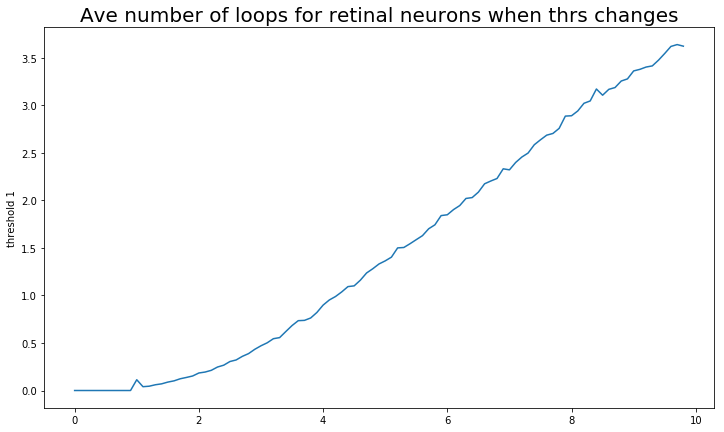

In [52]:
change_thrs = np.histogram(length_all_loops, bins=np.arange(0,10,.1))
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(np.arange(0,9.9,.1), change_thrs[0]/3143.0);
ax.set_title('Ave number of loops for retinal neurons when thrs changes', fontdict_title)

ax.set_ylabel('Ave number of loops per neuron');
ax.set_ylabel('threshold 1');

In [10]:
p10 = ['0.0 days\\n', 
       '0.5 day\\n',
       '1.0 days\\n', 
       '2.0 day\\n', 
       '3.0 day\\n', 
       '4.0 days\\n',
       '4.5 days\\n',
       '5.0 days\\n',
       '5.5 days\\n',
       '6.0 days\\n'
       '7.0 day\\n', 
       '8.0 day\\n', 
       '9.0 days\\n',
       '10.0 days\\n',
      '8.0 \\n',
      '9.0 \\n',
      '10.0 \\n']

max_age = list(neurons_v76['Max Age'])
index_up_to_p10 = []
for neuron_index in np.array(neurons_v76.index):
    if max_age[neuron_index] in p10:
        index_up_to_p10.append(neuron_index)
        
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']}
                ]


p10_neurons = loop_per_regions(regions=regions,
                                   neurons=neurons_v76.iloc[index_up_to_p10], 
                                   attribute_mat=attribute_mat[index_up_to_p10, :],
                                   labels_encoder=labels_encoder,
                                   labels_values=labels_values,
                                   n_loops_per_neuron=dis_2_20)

count = 1
ages_class = ['neonatal',  'young adult', 'young', 'adult', 'old']
loop_regions_ages = np.zeros([len(ages_class)+1, len(regions)])
loop_regions_ages[0, :] = np.array(p10_neurons)
for a in ages_class:
    
    regions_specific_age = loop_per_regions(regions=regions,
                                   neurons=neurons_v76, 
                                   attribute_mat=attribute_mat,
                                   labels_encoder=labels_encoder,
                        labels_values=labels_values+[{'age_classification': [a]}],
                                   n_loops_per_neuron=dis_2_20)    
    loop_regions_ages[count, :] = np.array(regions_specific_age)
    count = count +1
    print(count)

loop_regions_ages = np.array(loop_regions_ages)
loop_regions_ages[np.isnan(loop_regions_ages)]=0

2
3
4
5
6


In [ ]:
McNeuron.data_util.count_label(mouse_neurons, 'age_classification')

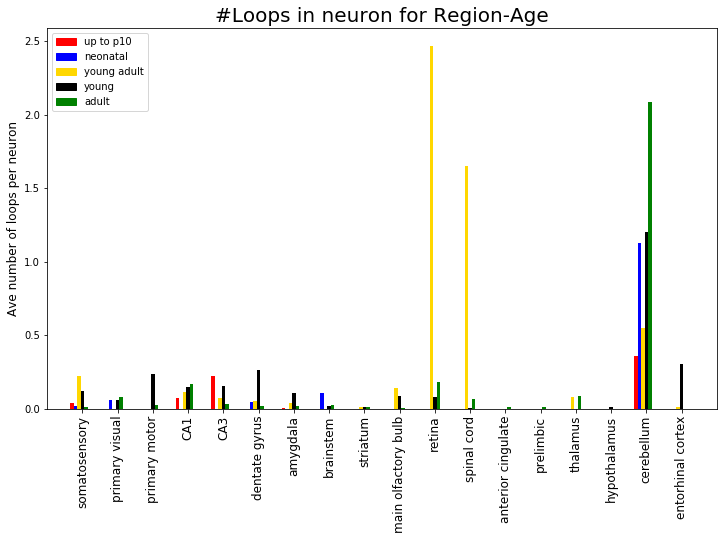

In [11]:
def plot_stat_ages_regions(title,
                           regions_name,
                           height,
                           classes=['up to p10', 'neonatal',  'young adult', 'young', 'adult'],
                           color=['r','b','gold', 'k','green','yellow']):
    n_regions = height.shape[1]
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_xlim(-1,n_regions)
    fontdict_title={'fontsize': 20, 'fontweight': 'medium'}
    fontdict_text={'fontsize': 12, 'fontweight': 'medium'}
    for i in range(height.shape[0]):

        ax.bar(x=np.arange(n_regions)+(i-3)/10, 
               height=height[i,:], 
               width=.1, color=color[i])
        
    
    ax.set_title(title, fontdict_title)

    ax.set_ylabel('Ave number of loops per neuron', fontdict=fontdict_text)
    ax.set_xticks(np.arange(n_regions))
    ax.set_xticklabels(regions_name,
                       rotation='vertical', 
                       fontdict=fontdict_text);
    handles = []
    for i in range(len(classes)):
        handles.append(mpatches.Patch(label=classes[i],color=color[i]))
    ax.legend(handles=handles)
plot_stat_ages_regions(title='#Loops in neuron for Region-Age', height=loop_regions_ages[:5,:], regions_name=regions_name)

In [ ]:
#mouse_neurons_loop['reference_pmid']

# Plotting
9 samples for the threshold = (1, 20) is shown.

In [12]:
labels_values = [ {'Physical Integrity':[
             'Dendrites & Axon Complete',
             'Dendrites & Axon Moderate',
             'Dendrites Complete',
             'Dendrites Complete, Axon Incomplete',
             'Dendrites Complete, Axon Moderate',
             'Dendrites Moderate',
             'Dendrites Moderate, Axon Complete',
             'Dendrites Moderate, Axon Incomplete',
             'Neurites Complete',
             'Neurites Moderate',
             'Processes Moderate']},
     {'experiment_condition':['Control']},
     {'Species Name':['rat', 'mouse']}
                ]
mouse_neurons = \
    McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
    attribute_mat=attribute_mat,
    labels_encoder=labels_encoder,
    labels_values=labels_values)
mouse_neurons_loop = neuron_with_features = pd.merge(mouse_neurons,
                                    dis_2_20, 
                                    on='NeuroMorpho.Org ID',
                                    how='inner') 
index = np.where(mouse_neurons_loop['n_loop']==10)[0]
len(index)

13

In [14]:
x = \
    McNeuron.data_util.get_neurons_with_given_values(neurons=neurons_v76,
    attribute_mat=attribute_mat,
    labels_encoder=labels_encoder,
    labels_values=labels_values+[{'brain_region':['retina']}])

McNeuron.data_util.count_label(x, 'age_classification')

[('young adult', 1654), ('adult', 1199), ('not reported', 264), ('young', 26)]

In [ ]:
set(x['Max Age'])

In [ ]:
np.histogram(mouse_neurons_loop['n_loop'])

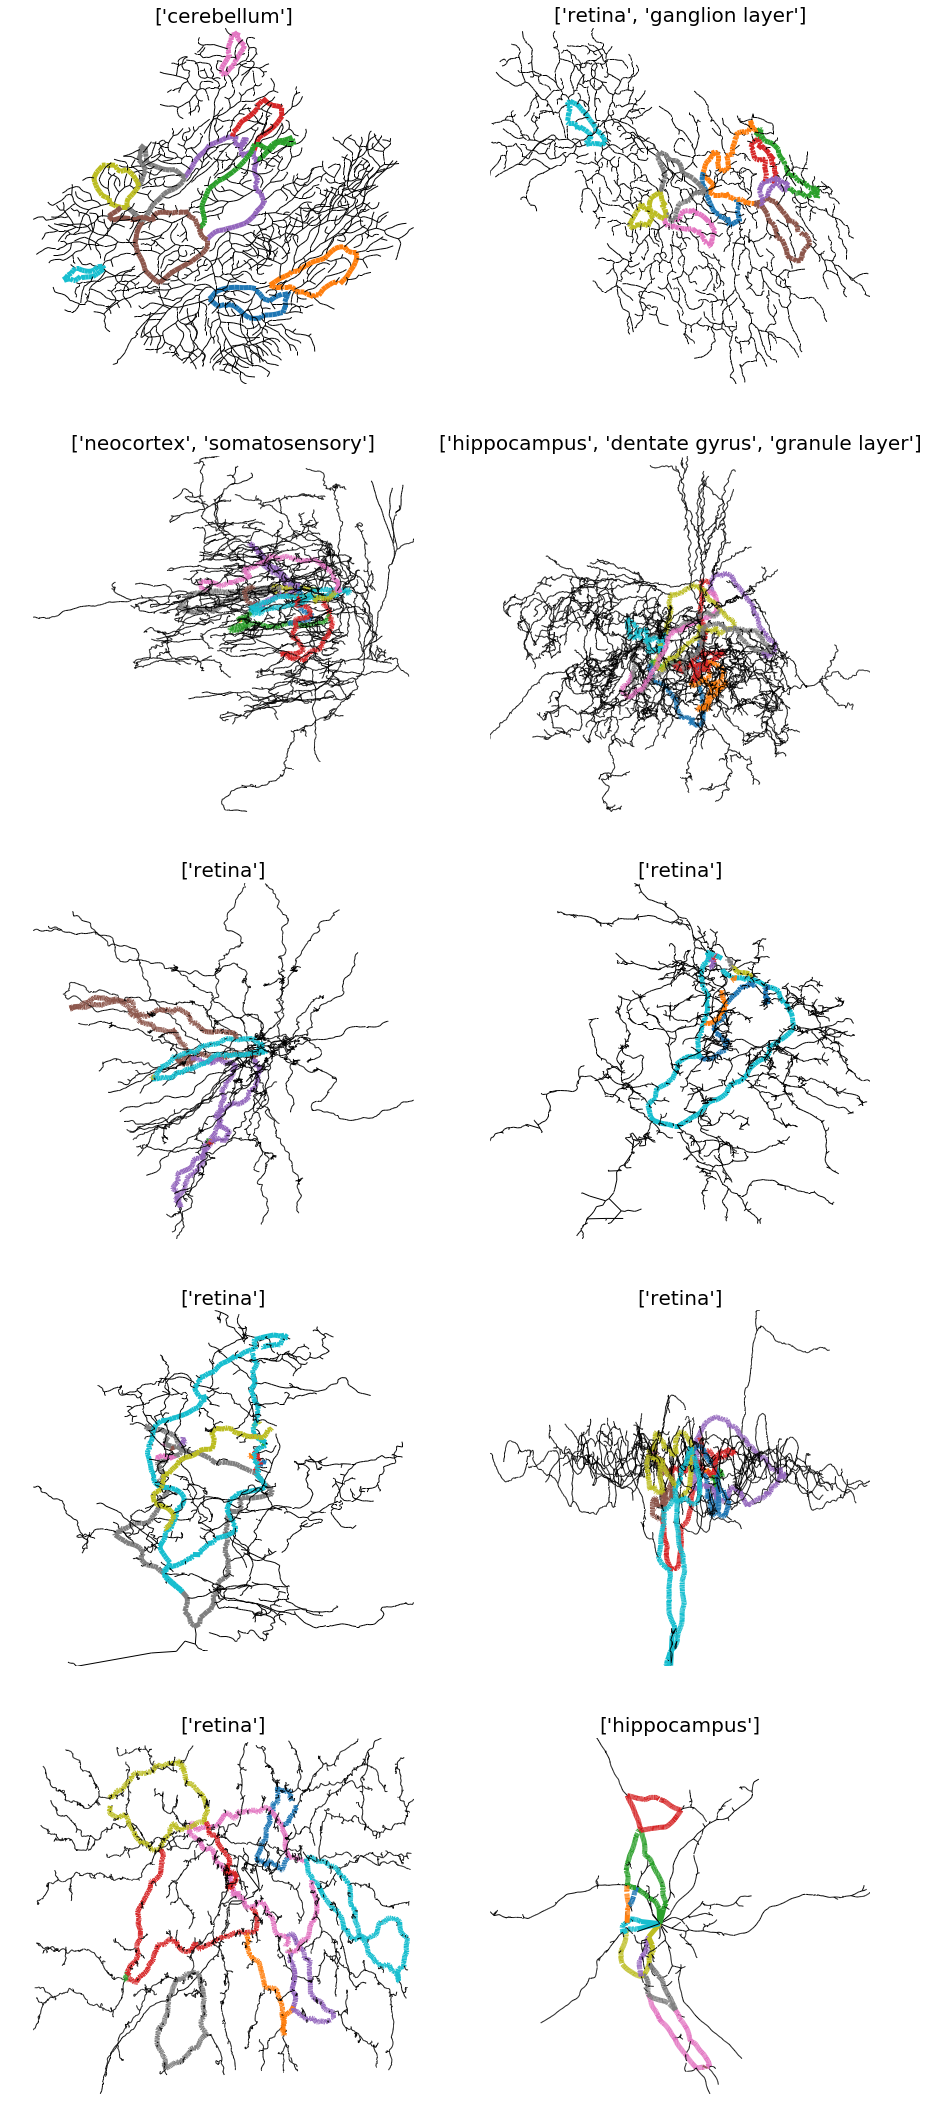

In [53]:
mouse_neurons_loop =  pd.merge(mouse_neurons,
                                    dis_2_20, 
                                    on='NeuroMorpho.Org ID',
                                    how='inner') 
index = np.where(mouse_neurons_loop['n_loop']==10)[0]
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15,38)
fontdict_title={'fontsize': 20, 'fontweight': 'medium'}
color_range = list(mcolors.TABLEAU_COLORS.keys())
for i in range(10):
    neuron = McNeuron.Neuron(mouse_neurons_loop['swc'][index[i]])

    n_loops, list_endpont_loops = \
    n_loops_in_neuron(neuron, thr_tips=2, thr_origin_loop=20)
    ax1 = ax[int(i/2),np.mod(i,2)]
    plot_2D(neuron, pass_ax=True, 
            ax=ax1,
            color_range=color_range,
            show_loop=list_endpont_loops, 
            line_width=1,
           color_line_width=5)
    ax1.set_title(mouse_neurons_loop['brain_region'][index[i]],
                 fontdict_title)

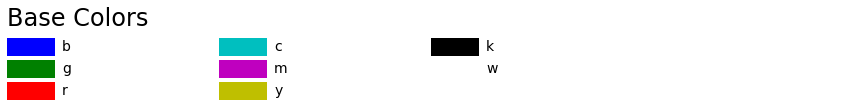

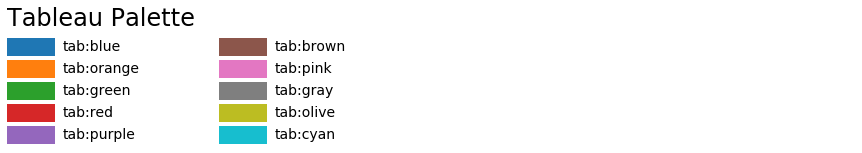

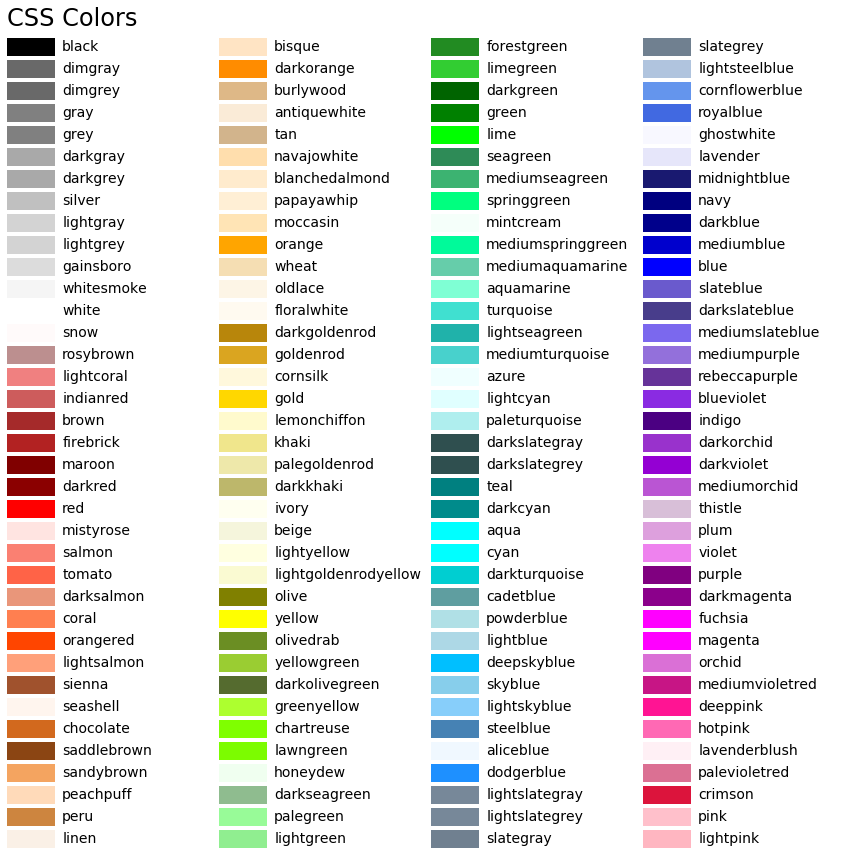

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    by_hsv = ((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                    for name, color in colors.items())
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)

    return fig

plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)
plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)

#sphinx_gallery_thumbnail_number = 3
plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

# Optionally plot the XKCD colors (Caution: will produce large figure)
#xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")
#xkcd_fig.savefig("XKCD_Colors.png")

plt.show()